HongAckermann_NatSyn
List_ACIE_THP-GNN_ee_withoutT.csv
List_ACIE_THF-GNN_ee_withT.csv
List_ACIE_THF-GNN_ee_withoutT.csv
Denmark_Science-GNN_ee_withoutT.csv
List_ACIE_THF-GNN_ddg_withoutT.csv
HongAckermann_NatSyn-GNN_ddg_withT.csv
Denmark_OPRD-GNN_ddg_withT.csv
HongAckermann_NatSyn-GNN_ddg_withoutT.csv
Denmark_OPRD-GNN_ddg_withoutT.csv
List_ACIE_THF-GNN_ddg_withT.csv
Denmark_OPRD-GNN_ee_withT.csv
HongAckermann_NatSyn-GNN_ee_withoutT.csv
SigmanToste_Science-GNN_ddg_withoutT.csv
Sunoj_PNAS-GNN_ee_withoutT.csv
Sunoj_PNAS-GNN_ddg_withoutT.csv
Sunoj_PNAS-GNN_ddg_withT.csv
Denmark_Science-GNN_ddg_withT.csv
Sunoj_PNAS-GNN_ee_withT.csv
SigmanToste_Science-GNN_ddg_withT.csv
List_ACIE_THP-GNN_ee_withT.csv
SigmanToste_Science-GNN_ee_withoutT.csv
List_ACIE_THP-GNN_ddg_withT.csv
Denmark_Science-GNN_ee_withT.csv
List_ACIE_THP-GNN_ddg_withoutT.csv
SigmanToste_Science-GNN_ee_withT.csv
Denmark_OPRD-GNN_ee_withoutT.csv
Denmark_Science-GNN_ddg_withoutT.csv
HongAckermann_NatSyn-GNN_ee_withT.csv
Now for ddg

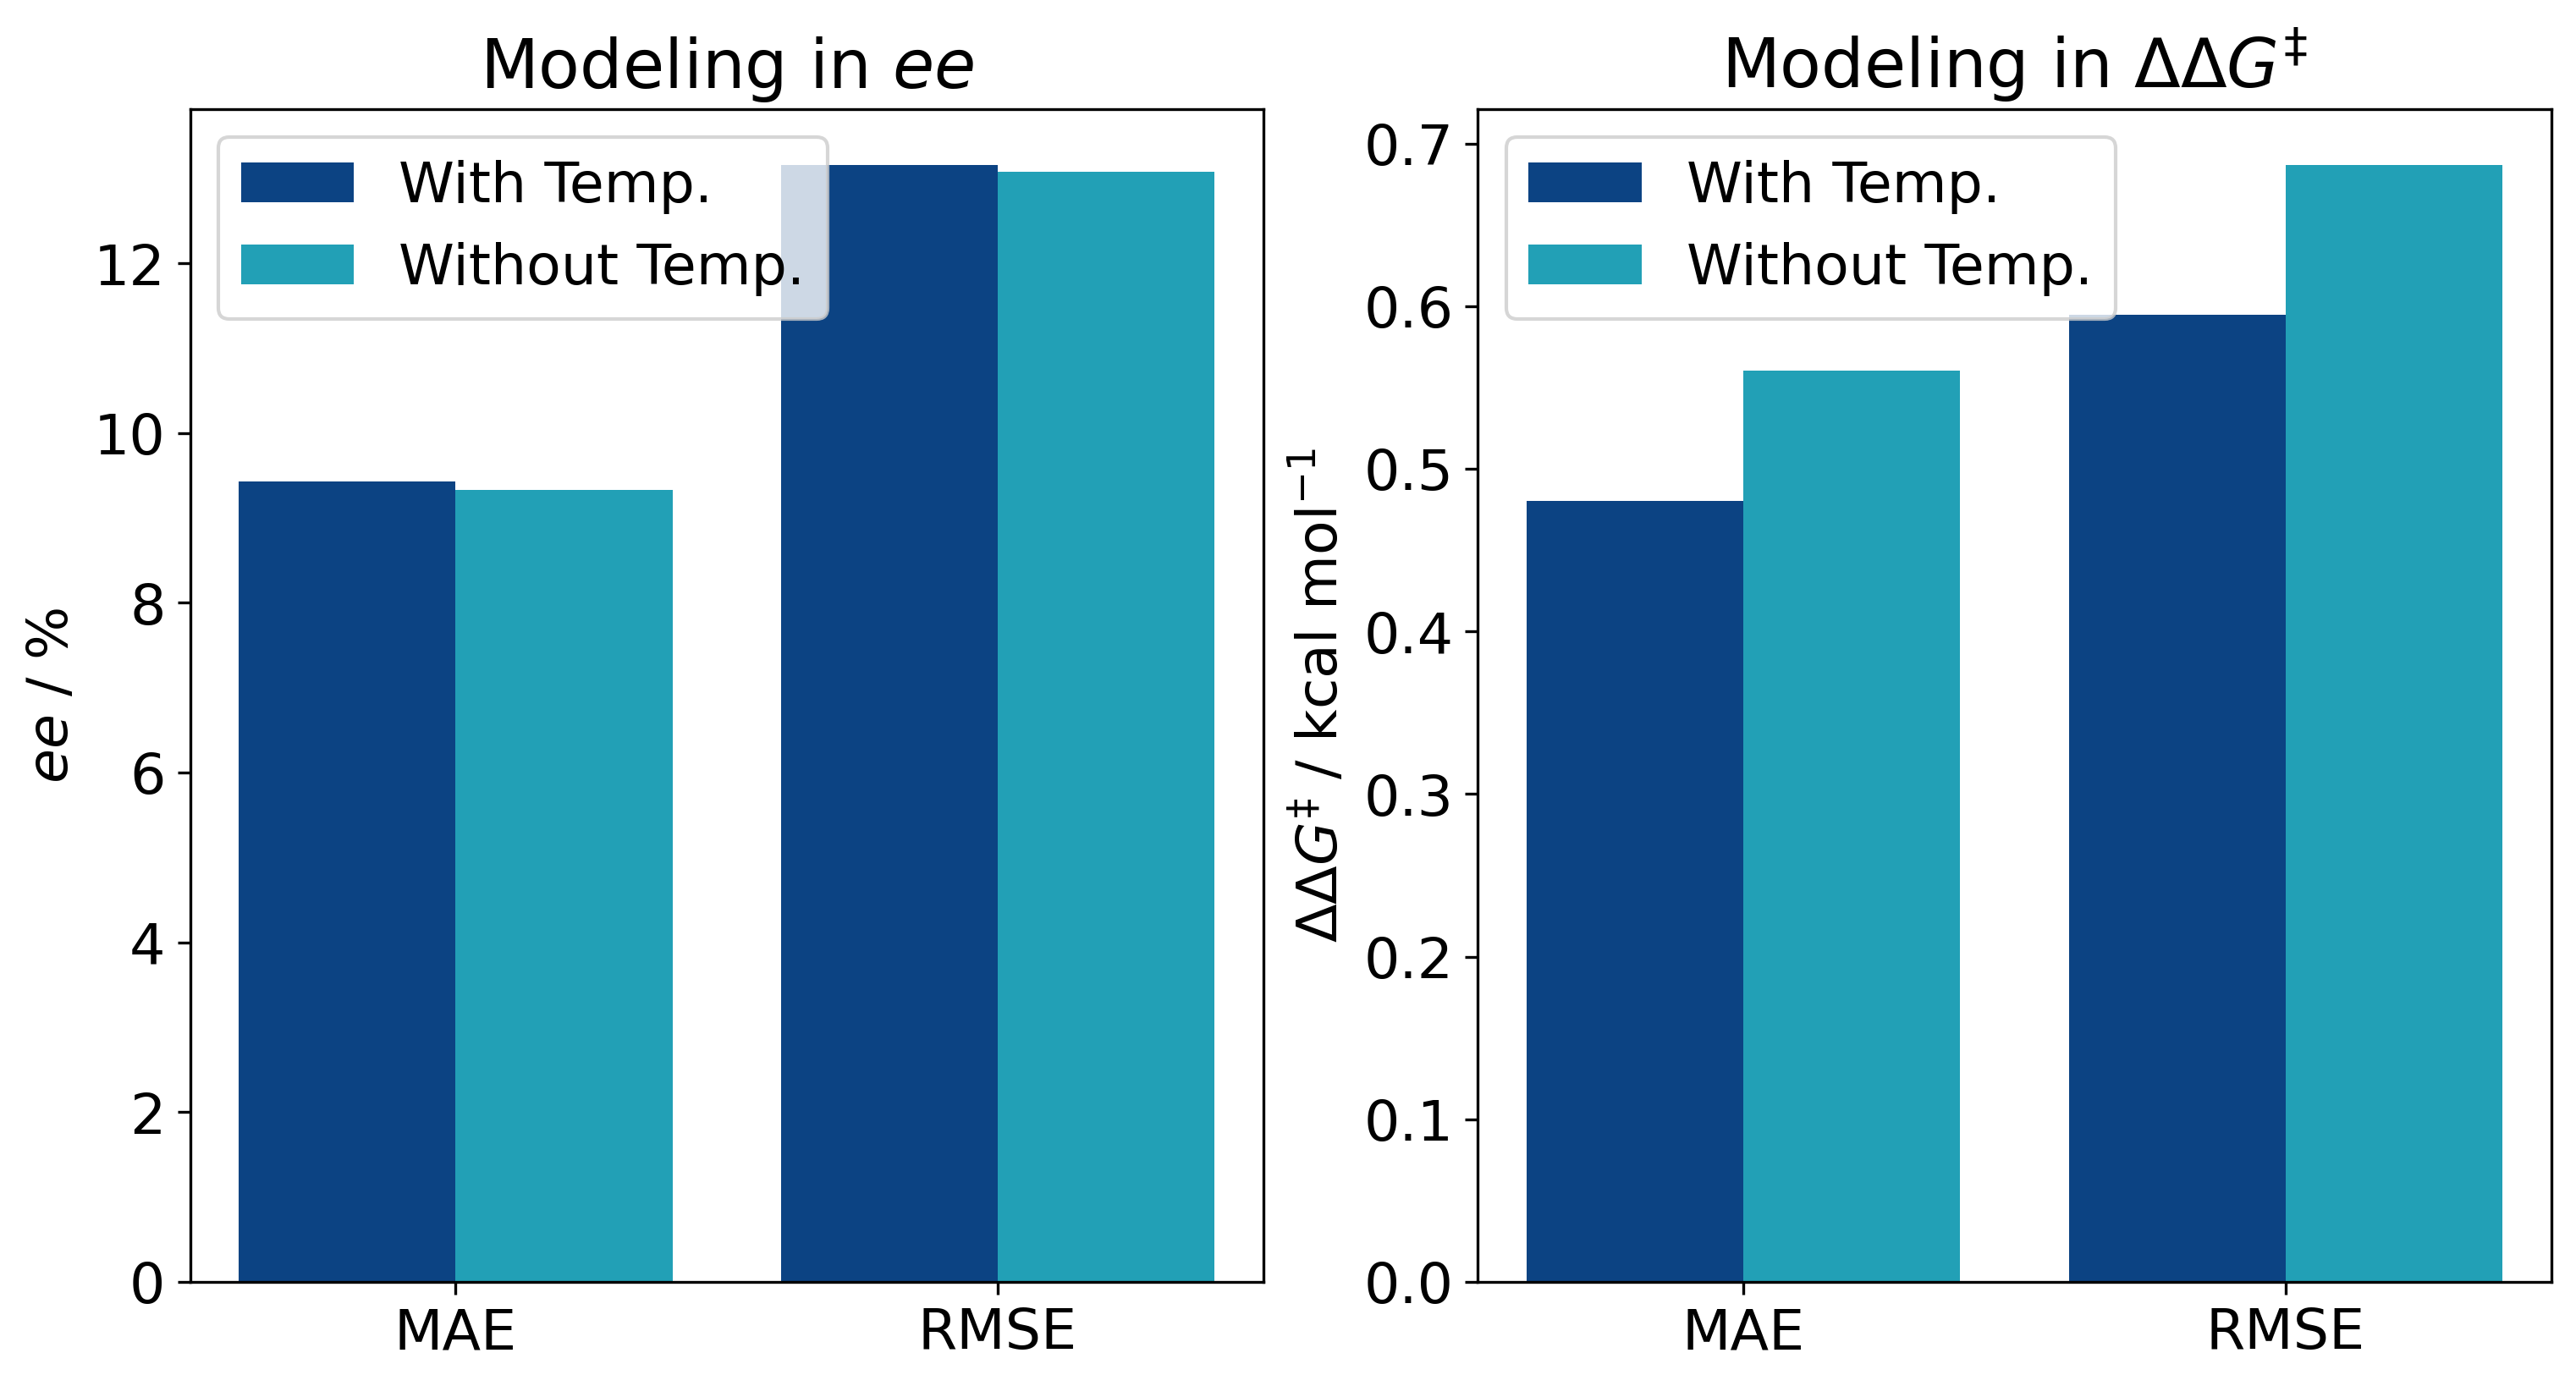

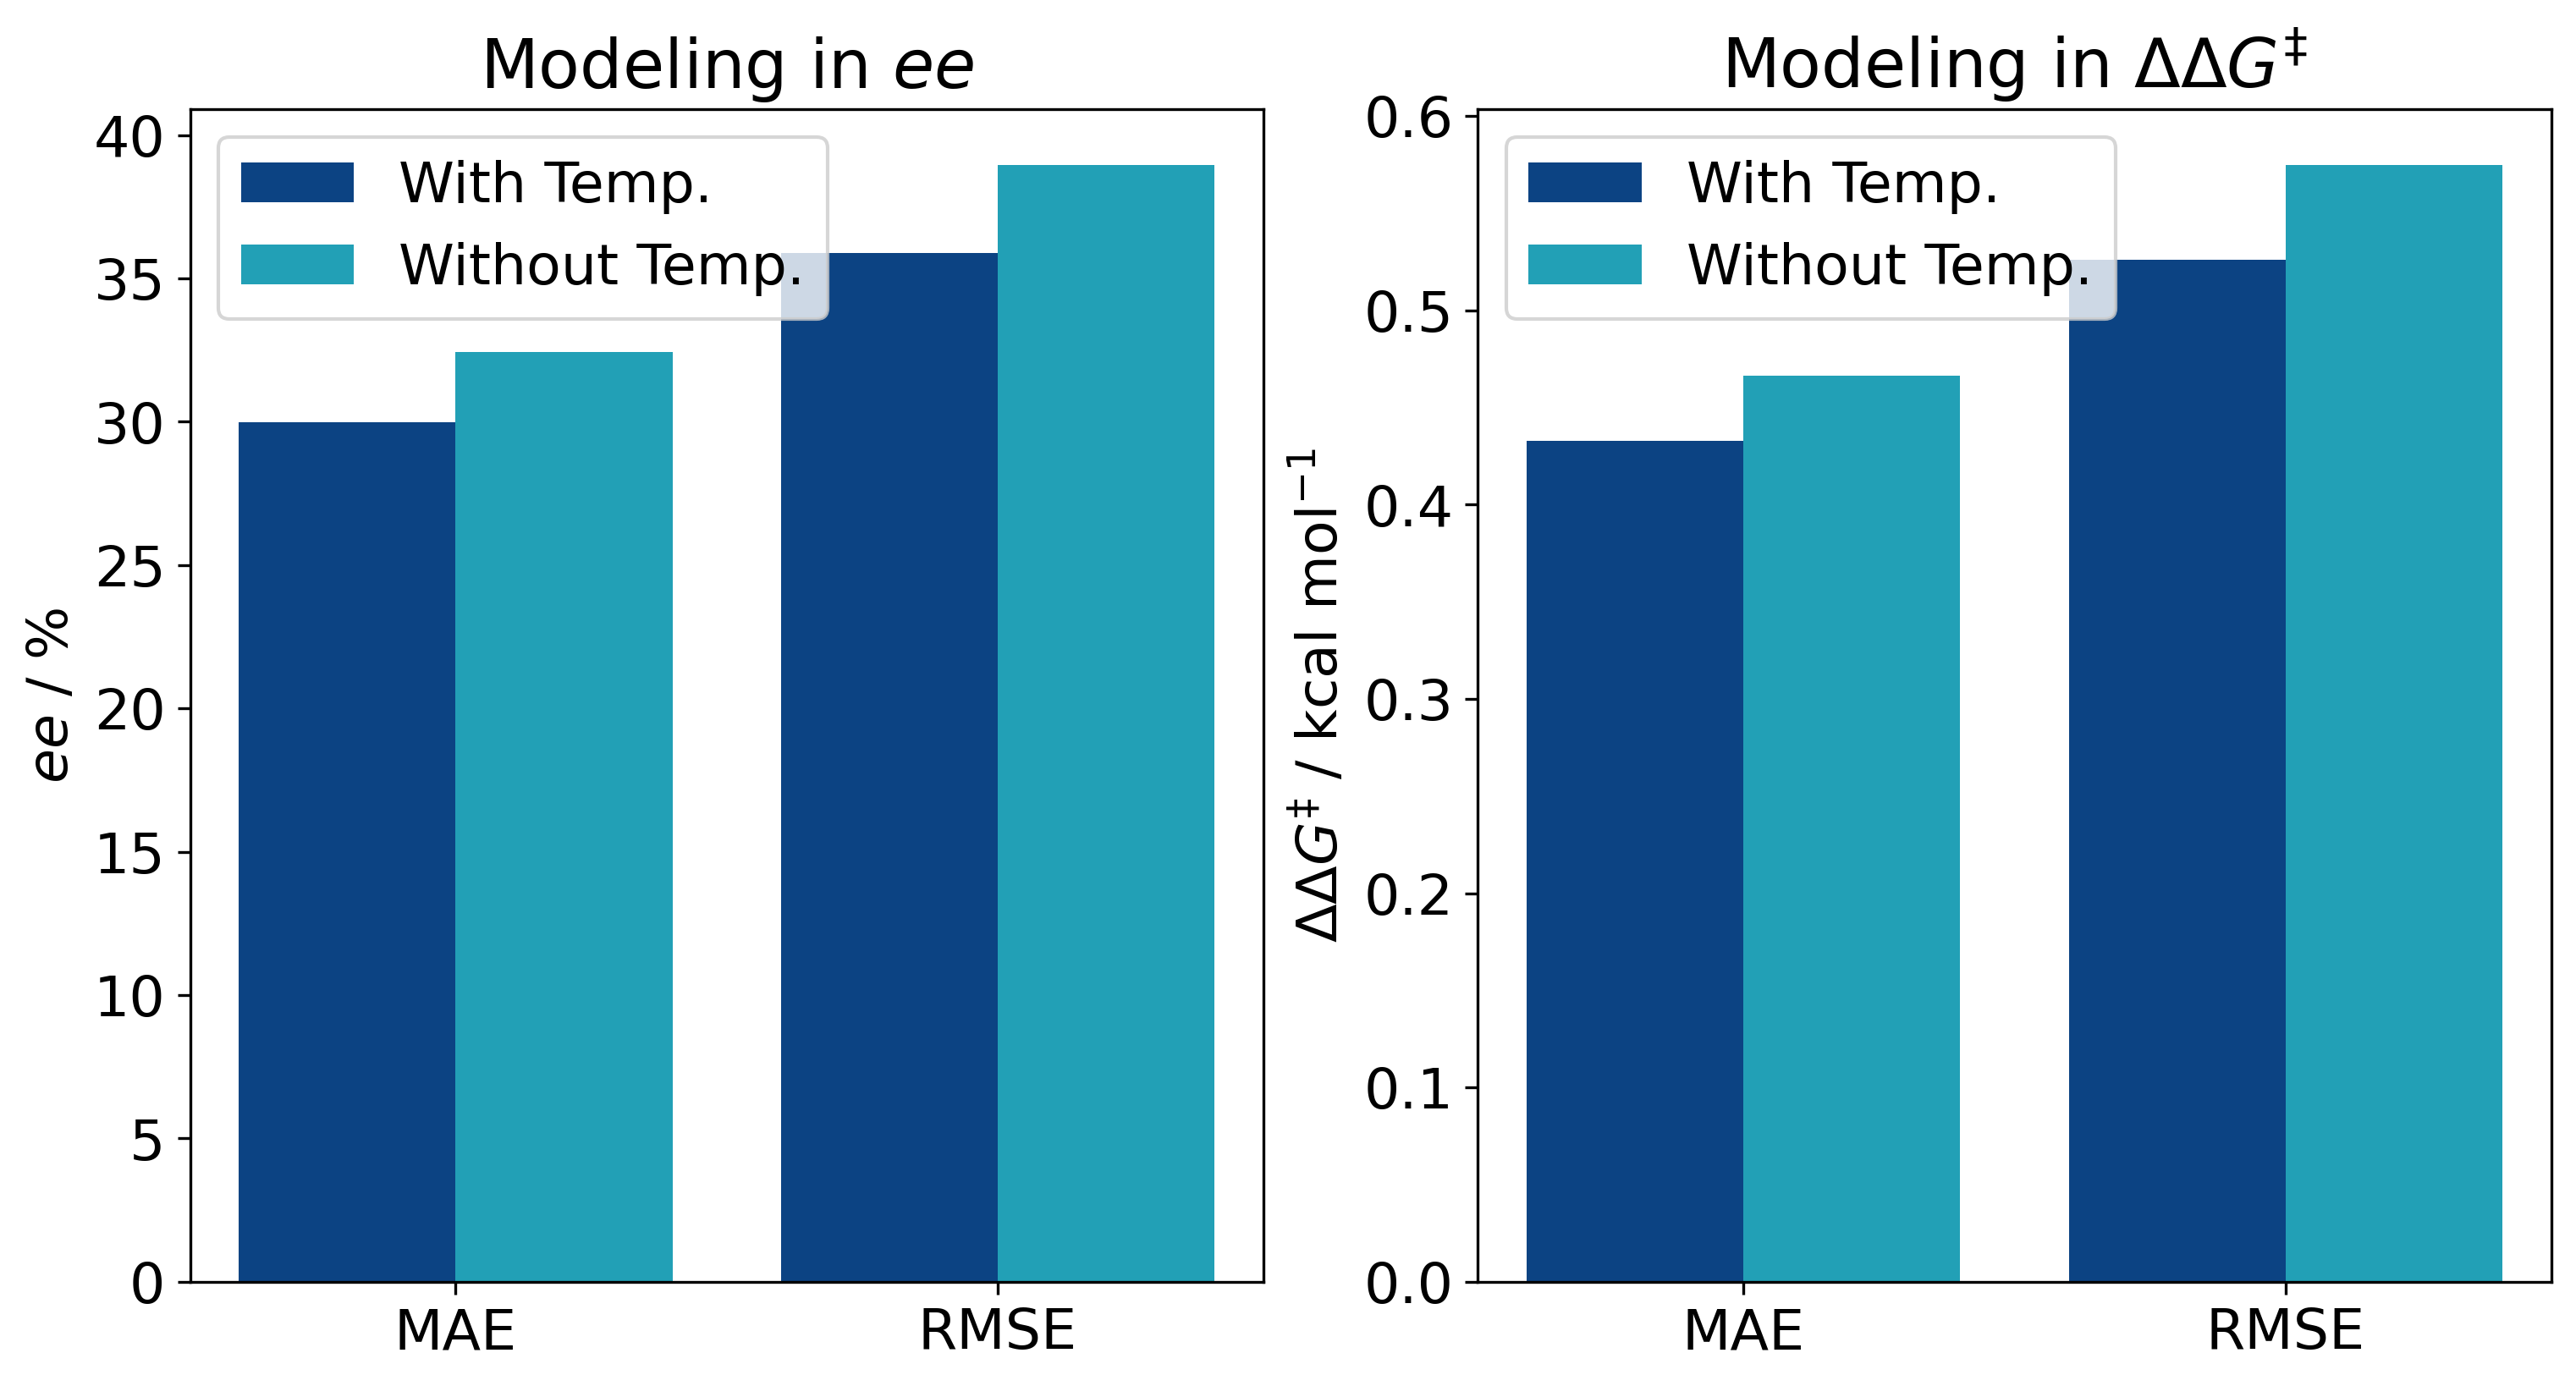

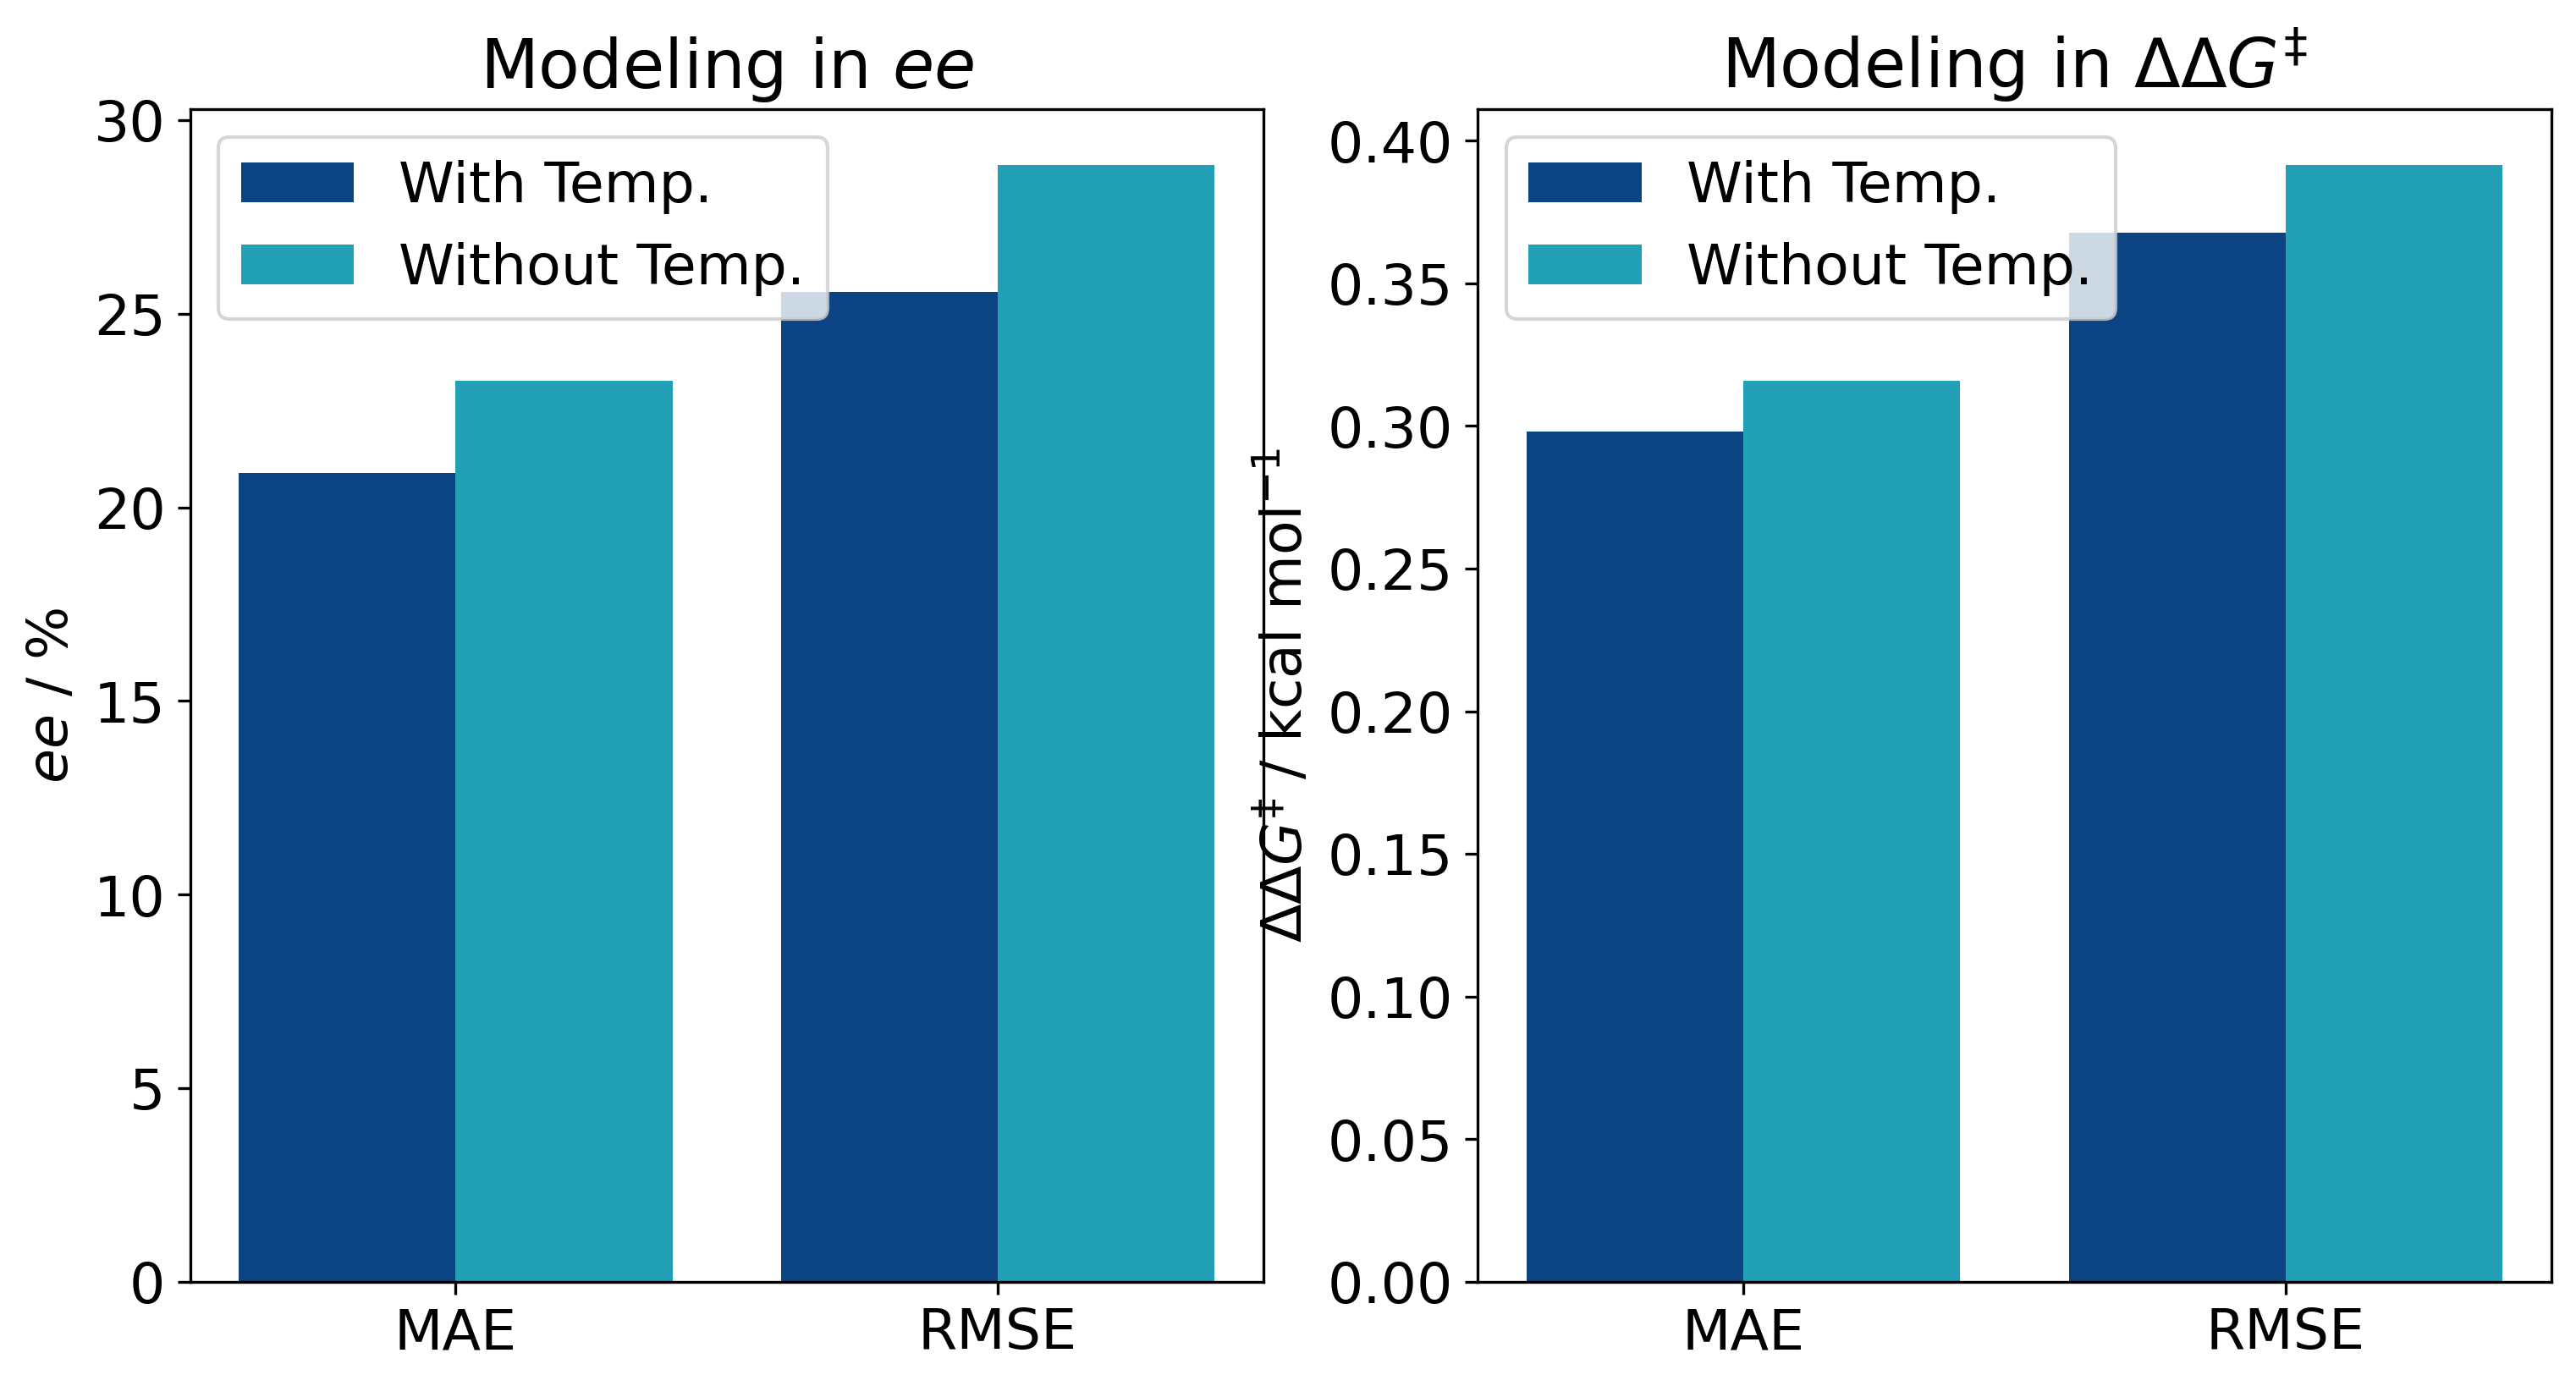

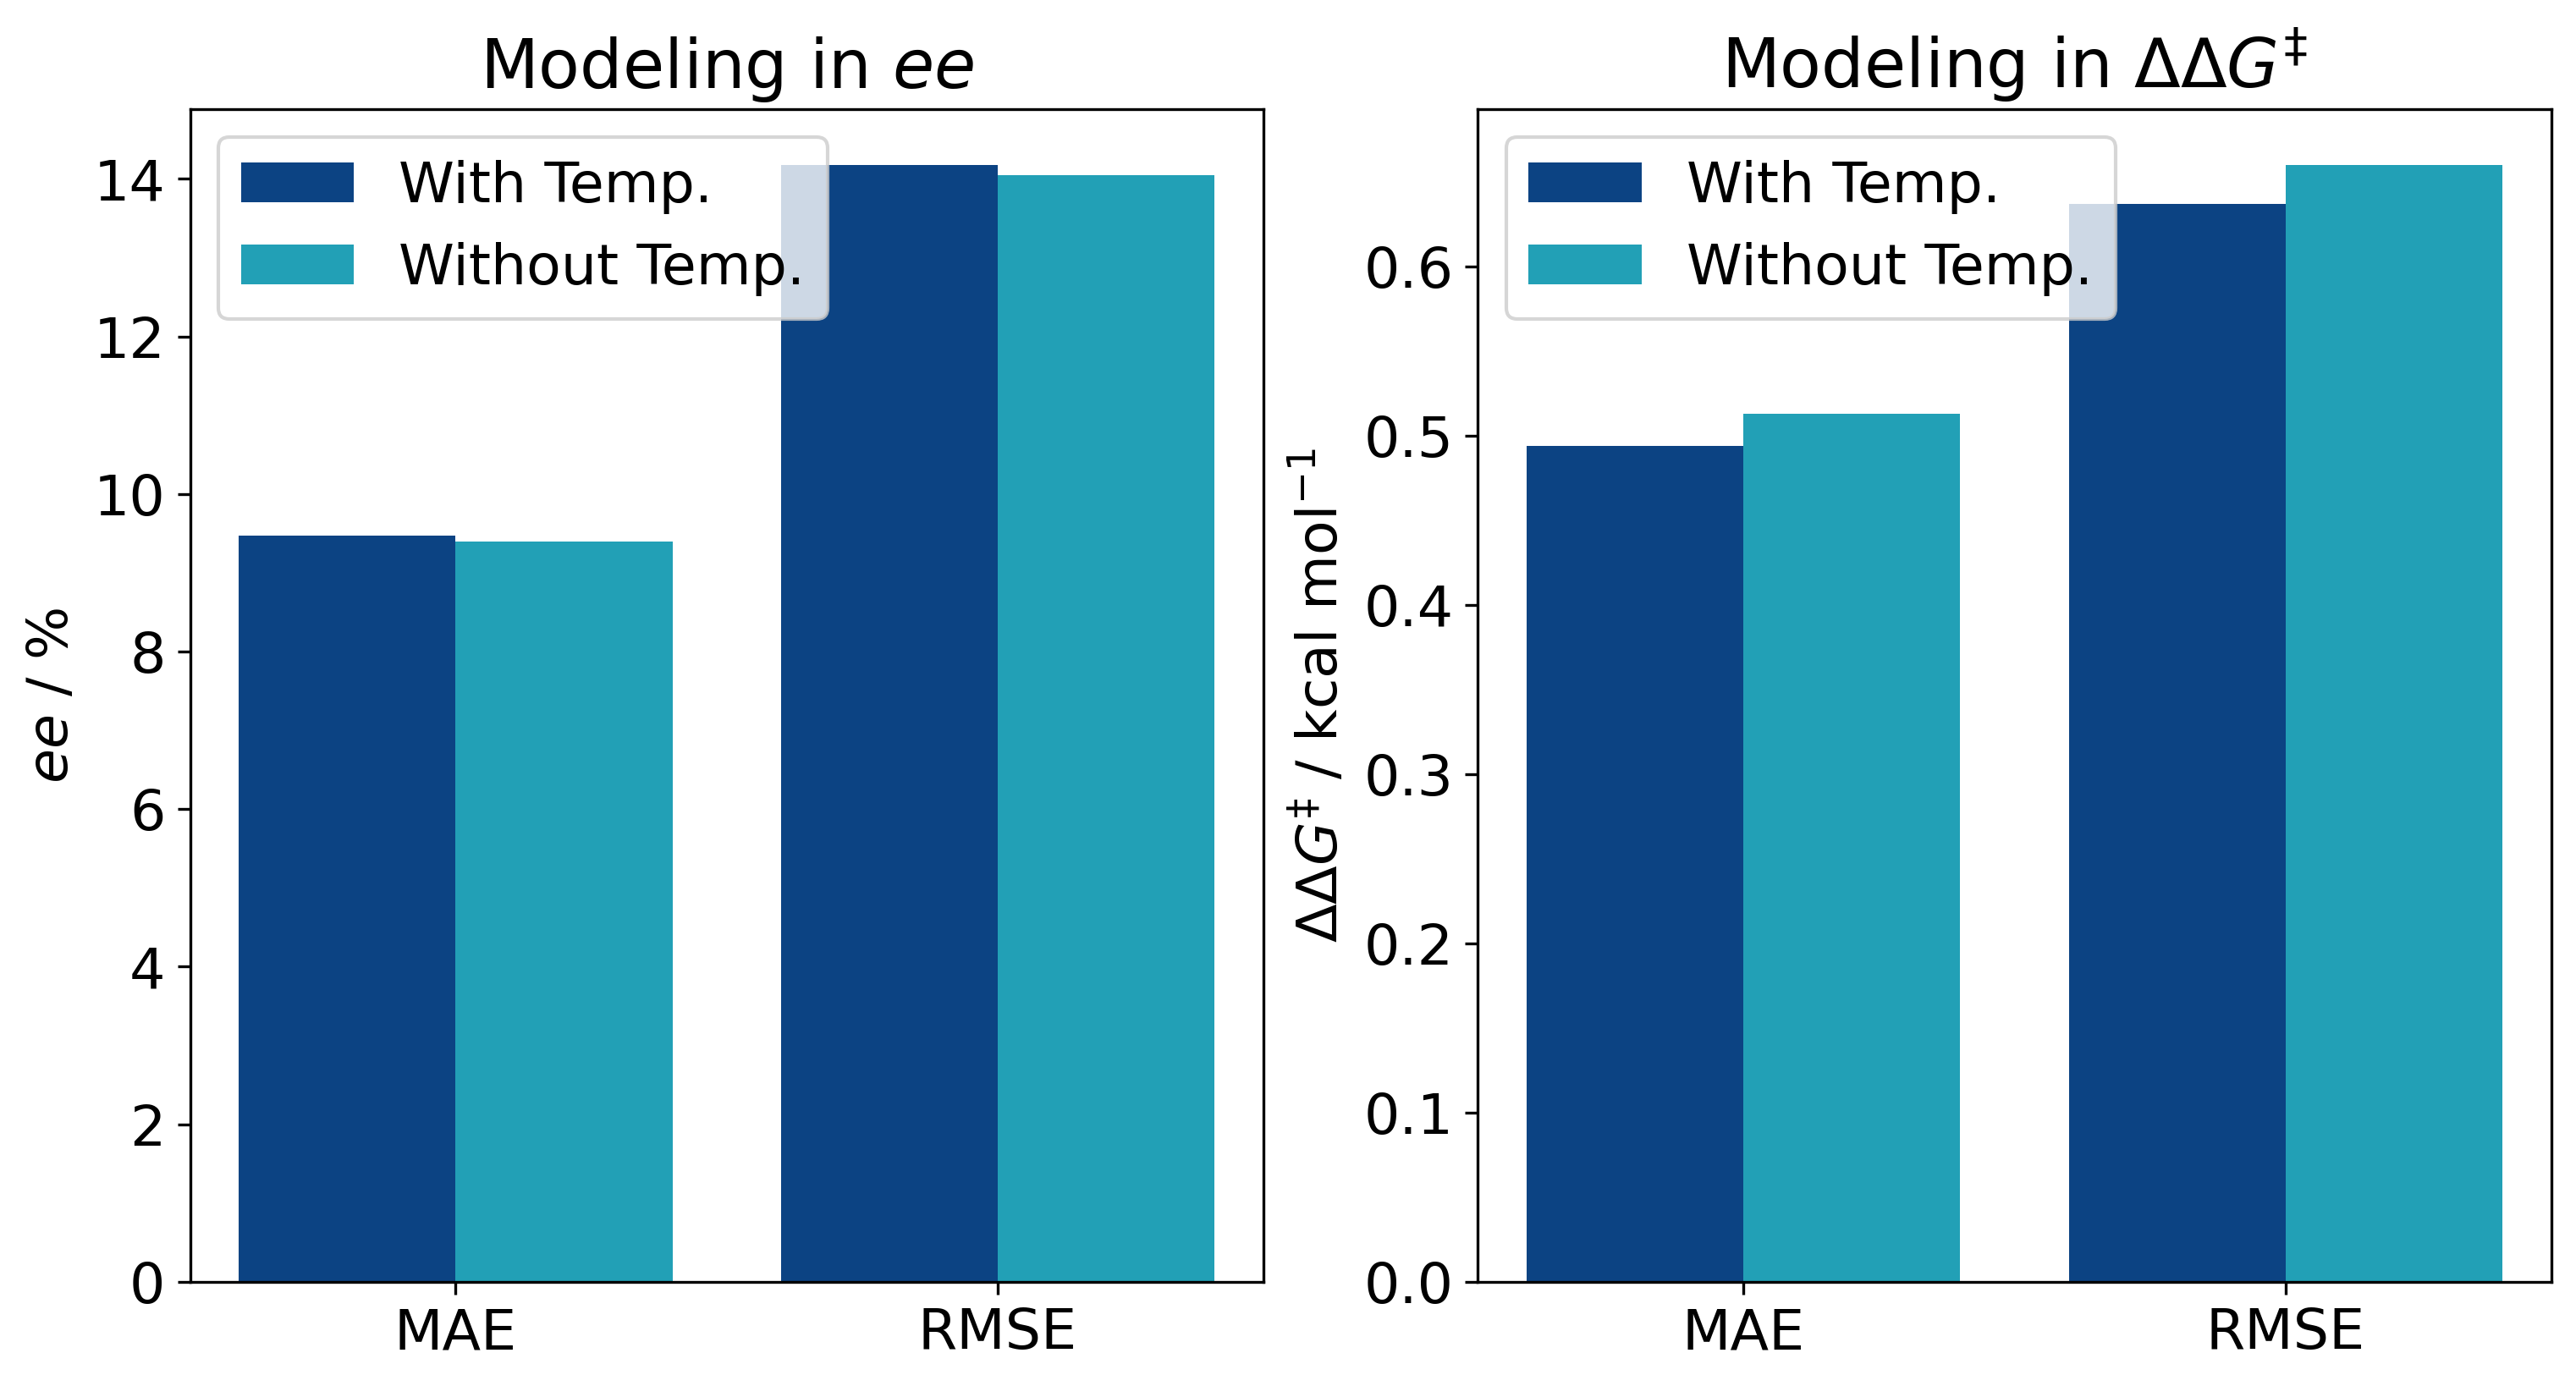

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os
import pandas as pd

fontsize = 16
one_plot = False
box_plot = False
only_test = True

check_gnn = True

check_shallow = False
check_fp = False
check_descriptors = False

path_files = 'predictions_mr_best'
mode = 'MAE' # MAE, RMSE, R2, er 

gensch_palette = ['#0C4383',
                '#22A0B6',
                '#46E0A6',
                '#7B1346',
                '#CB0C59']
plt.style.use('default')
plt.rcParams['font.size'] =fontsize

# all possible combinations
dataset_list = ['HongAckermann_NatSyn', 'List_ACIE_THF', 'List_ACIE_THP',  'Sunoj_PNAS']
modes = ['fp',
         'descriptors',
         'GNN']
targets = ['ee',
           'ddg']
tmodes = ['withT',
          'withoutT']
methods = ['ElasticNetCV',
           'ExtraTreesRegressor',
           'GaussianProcess',
           'GradientBoostingRegressor',
           'KernelRidge_poly',
           'KernelRidge_rbf',
           'KNeighborsRegressor',
           'LassoCV',
           'LinearRegression',
           'RandomForestRegressor',
           'RidgeCV',
           'GNN']
lin_methods = ['ElasticNetCV',
               'LassoCV',
               'LinearRegression',
                'RidgeCV']
nonlin_methods = ['ExtraTreesRegressor',
                    'GaussianProcess',
                    'GradientBoostingRegressor',
                    'KernelRidge_poly',
                    'KernelRidge_rbf',
                    'KNeighborsRegressor',
                    'RandomForestRegressor',
                    'GNN']

best_models = {
    'Order' : ['FP', 'Desc-Lin', 'Desc-Nonlin', 'GNN'],
    'Denmark_Science' : [],
    'Doyle_JACS' : [],
    'HongAckermann_NatSyn' : [],
    'List_ACIE_THF' : [],
    'List_ACIE_THP' : [],
    'SigmanBiscoe_Science' : [],
    'SigmanToste_JACS' : [],
    'SigmanToste_Science' : [],
    'Sunoj_JPC': [],
    'Sunoj_PNAS' : [],
}

def ee2er(ee):
    '''
    ee in %
    '''
    epsilon = 1e-7 #  for numerical stability
    er = (1 + ee/100) / (1 - ee/100 + epsilon)

    return er

def ddg2er(ddg, T):
    '''
    ddg in kcal/mol
    T in Kelvin
    er = exp(-ddg/RT)
    ee = 100 * (er - 1) / (er + 1)
    '''
    # prevent overflow
    if ddg > 10:
        ddg = 10
    T = float(T)
    R_const = 8.31446261815324/1000 # kJ / (mol K)
    ddg *= 4.1839954 # convert from kcal/mol to kJ/mol
    er = np.exp(ddg / (R_const * T))
    return er


def calc_switch(dataframe, T_frame, tc):
    df_switched = pd.DataFrame()
    tc_sw = 'something_wrong_in_switching'
    df_list = []
    dataframe['T'] = T_frame['T']
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: ee2er(row[col]), axis=1)
                tc_sw = 'ddg'
            else:
                df_col = dataframe.apply(lambda row: ddg2er(row[col], row['T']), axis=1)
                tc_sw = 'ee'
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    
    return df_switched

def load_both_datasets_v2(dataset, prediction_dataset):

    # original data
    df_orig = pd.read_csv(f'../code/datasets_230520/{dataset}.csv')
    df_pred = pd.read_csv(prediction_dataset, delimiter=',')
    df_pred = df_pred.dropna(axis=1, how='any')

    return df_orig, df_pred

def calc_baseline(dataframe, tc):
    mean_val = dataframe[tc].mean()
    diff = dataframe[tc] - mean_val
    mae_baseline = abs(diff).mean()
    rmse_baseline = np.sqrt((diff**2).mean())
    # calc r2 baseline
    r2_baseline = r2_score(dataframe[tc], np.ones(len(dataframe))*mean_val)
    return mae_baseline, rmse_baseline, r2_baseline

def calc_metrics(data_orig, data_pred, only_test = True, baselines = None):
    '''
    baselines = [mae_baseline, rmse_baseline]
    '''
    # only from test set
    maes = []
    rmses = []
    r2s = []
    for col in data_pred.columns:
        if not 'Unnamed' in col and not 'T' in col:
            if only_test:
                train_idx, test_idx = train_test_split(range(len(data_pred)), test_size = 0.2, random_state = int(col))
                data_pred_test = data_pred[col].iloc[test_idx]
                data_orig_test = data_orig.iloc[test_idx]
            else:
                data_pred_test = data_pred[col]
                data_orig_test = data_orig
            mae = mean_absolute_error(data_orig_test, data_pred_test)
            rmse = np.sqrt(mean_squared_error(data_orig_test, data_pred_test))
            r2 = r2_score(data_orig_test, data_pred_test)

            if baselines != None:
                mae = mae / baselines[0]
                rmse = rmse / baselines[1]
                r2 = r2 / (baselines[2] + 1e-7)

            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)

    mae = np.mean(maes)
    rmse = np.mean(rmses)
    r2 = np.mean(r2s)
    return mae, rmse, r2

# list all files in folder
files = os.listdir(f'../{path_files}/')

# first the best models for each dataset have to be found
# rubriks are FP, Desciptors-Lin., Descriptors-Nonlin., GNN

# list all files in folder
files = os.listdir(f'../predictions_mr_best/')

if check_gnn:
    gnn_check = 'GNN'
else:
    gnn_check = '_' # matches in every case

# Loop over the datasets
if one_plot:
    mae_T_Yes_ee_list = []
    rmse_T_Yes_ee_list = []
    mae_T_No_ee_list = []
    rmse_T_No_ee_list = []
    mae_T_Yes_ddG_list = []
    rmse_T_Yes_ddG_list = []
    mae_T_No_ddG_list = []
    rmse_T_No_ddG_list = []
    for dataset in dataset_list:

        # loop over files
        for file in files:
            if dataset in file and 'ee' in file:
                prediction_dataset = f'../predictions_mr_best/{file}'
                df_orig, df_preds = load_both_datasets_v2(dataset, prediction_dataset)
                
                if mode == 'er':
                    df_orig['ee'] = df_orig['ee'].apply(lambda x: ee2er(x))
                mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, 'ee')
                mae_ee, rmse_ee, r2_ee = calc_metrics(df_orig['ee'],
                                            df_preds,
                                            only_test = True,
                                            baselines=[mae_baseline,
                                                        rmse_baseline,
                                                        r2_baseline])
                if len(df_preds) != 0 and mae_ee < 20:
                        if 'withT' in file:
                            mae_T_Yes_ee_list.append(mae_ee)
                            rmse_T_Yes_ee_list.append(rmse_ee)
                        else:
                            mae_T_No_ee_list.append(mae_ee)
                            rmse_T_No_ee_list.append(rmse_ee)

    mae_T_Yes_ee = np.mean(mae_T_Yes_ee_list)
    rmse_T_Yes_ee = np.mean(rmse_T_Yes_ee_list)
    mae_T_No_ee = np.mean(mae_T_No_ee_list)
    rmse_T_No_ee = np.mean(rmse_T_No_ee_list)

    # Create the plot for ee
    labels = ['MAE', 'RMSE']

    T_Yes_values = [mae_T_Yes_ee_list, rmse_T_Yes_ee_list]
    T_No_values = [mae_T_No_ee_list, rmse_T_No_ee_list]

    data_to_plot = [T_Yes_values[0], T_No_values[0], T_Yes_values[1], T_No_values[1]]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=300)

    if box_plot:
        positions = [1, 2, 4, 5]
        bp1 = ax[0].boxplot(data_to_plot[::2], positions=[positions[0], positions[2]], widths=0.6, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor(gensch_palette[0])

        bp2 = ax[0].boxplot(data_to_plot[1::2], positions=[positions[1], positions[3]], widths=0.6, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor(gensch_palette[1])
        
        ax[0].legend([bp1["boxes"][0], bp2["boxes"][0]], ['With Temp.', 'Without Temp.'], loc='upper right')

        ax[0].set_xticks([np.mean(pair) for pair in zip(positions[::2], positions[1::2])])
        ax[0].set_xticklabels(labels)
        ax[0].set_ylabel(r'$ee$ / %')
        ax[0].set_title('Modeling in $ee$')

    else:
        x = range(len(labels))
        width = 0.4
        # Create the bar plot for ee
        T_Yes_values = [mae_T_Yes_ee, rmse_T_Yes_ee]
        T_No_values = [mae_T_No_ee, rmse_T_No_ee]

        ax[0].bar([i - 0.2 for i in x], T_Yes_values, width, label='With Temp.', color=gensch_palette[0])
        ax[0].bar([i + 0.2 for i in x], T_No_values, width, label='Without Temp.', color=gensch_palette[1])

        ax[0].set_xticks(x)
        ax[0].set_xticklabels(labels)
        ax[0].legend()
        ax[0].set_ylabel(r'$ee$ / \%')
        ax[0].set_title('Modeling in $ee$')

    print('Now for ddg')
    for dataset in dataset_list:

        # list all files in folder
        files = os.listdir(f'../predictions_mr_best/')

        # loop over files
        for file in files:
            if dataset in file and 'ddg' in file:
                prediction_dataset = f'../predictions_mr_best/{file}'
                df_orig, df_preds = load_both_datasets_v2(dataset, prediction_dataset)

                if mode == 'er':
                    df_orig['ddg'] = df_orig.apply(lambda row: ddg2er(row['ddg'], row['T']), axis=1)
                mae_ddg, rmse_ddg, r2_ddg = calc_metrics(df_orig['ddg'],
                                            df_preds,
                                            only_test = True)
                if len(df_preds) != 0 and mae_ddg < 10:
                    if 'withT' in file:
                        mae_T_Yes_ddG_list.append(mae_ddg)
                        rmse_T_Yes_ddG_list.append(rmse_ddg)
                    else:
                        mae_T_No_ddG_list.append(mae_ddg)
                        rmse_T_No_ddG_list.append(rmse_ddg)

    mae_T_Yes_ddG = np.mean(mae_T_Yes_ddG_list)
    rmse_T_Yes_ddG = np.mean(rmse_T_Yes_ddG_list)
    mae_T_No_ddG = np.mean(mae_T_No_ddG_list)
    rmse_T_No_ddG = np.mean(rmse_T_No_ddG_list)

    if box_plot:
        # Create the box plot for ddG
        T_Yes_values_ddG = [mae_T_Yes_ddG_list, rmse_T_Yes_ddG_list]
        T_No_values_ddG = [mae_T_No_ddG_list, rmse_T_No_ddG_list]

        data_to_plot_ddG = [T_Yes_values_ddG[0], T_No_values_ddG[0], T_Yes_values_ddG[1], T_No_values_ddG[1]]

        positions = [1, 2, 4, 5]
        bp1 = ax[1].boxplot(data_to_plot_ddG[::2], positions=[positions[0], positions[2]], widths=0.6, patch_artist=True)
        for patch in bp1['boxes']:
            patch.set_facecolor(gensch_palette[0])

        bp2 = ax[1].boxplot(data_to_plot_ddG[1::2], positions=[positions[1], positions[3]], widths=0.6, patch_artist=True)
        for patch in bp2['boxes']:
            patch.set_facecolor(gensch_palette[1])
        
        ax[1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['With Temp.', 'Without Temp.'], loc='upper right')

        ax[1].set_xticks([np.mean(pair) for pair in zip(positions[::2], positions[1::2])])
        ax[1].set_xticklabels(labels)
        ax[1].set_ylabel(r'$\Delta\Delta G^‡$ / kcal mol$^{-1}$')
        ax[1].set_title(r'Modeling in $\Delta\Delta G^‡$')
        plt.savefig(f'figure7_all_box_{only_test}.png', dpi=300)
    else:
        width = 0.4
        x = range(len(labels))
        # Create the bar plot for ddG
        T_Yes_values = [mae_T_Yes_ddG, rmse_T_Yes_ddG]
        T_No_values = [mae_T_No_ddG, rmse_T_No_ddG]

        ax[1].bar([i - 0.2 for i in x], T_Yes_values, width, label='With Temp.', color=gensch_palette[0])
        ax[1].bar([i + 0.2 for i in x], T_No_values, width, label='Without Temp.', color=gensch_palette[1])

        ax[1].set_xticks(x)
        ax[1].set_xticklabels(labels)
        ax[1].legend()
        ax[1].set_ylabel(r'$\Delta\Delta G^‡$ / kcal mol$^{-1}$')
        ax[1].set_title(r'Modeling in $\Delta\Delta G^‡$')
        plt.savefig(f'figure7_all_bar_{only_test}.png', dpi=300)








else:
    criteria_not_met = []
    crit_failed_counter_ee = 0
    crit_failed_counter_ddg = 0
    labels = ['MAE', 'RMSE']
    for dataset in dataset_list:
        print(dataset)

        mae_T_Yes_ee_list = []
        rmse_T_Yes_ee_list = []
        mae_T_No_ee_list = []
        rmse_T_No_ee_list = []
        mae_T_Yes_ddG_list = []
        rmse_T_Yes_ddG_list = []
        mae_T_No_ddG_list = []
        rmse_T_No_ddG_list = []

        # loop over files
        for file in files:
            if not gnn_check in file:    
                continue
            if check_shallow:
                if 'GNN' in file:
                    continue
                if check_descriptors:
                    if 'fp' in file:
                        continue
                elif check_fp:
                    if 'descriptors' in file:
                        continue

            print(file)
            if dataset in file and 'ee' in file:
                prediction_dataset = f'../predictions_mr_best/{file}'
                df_orig, df_preds = load_both_datasets_v2(dataset, prediction_dataset)
                # baseline mae
                baseline_mae = df_orig['ee'].apply(lambda x: abs(x - df_orig['ee'].mean())).mean()
                mae_ee, rmse_ee, r2_ee = calc_metrics(df_orig['ee'], df_preds, only_test)
                if len(df_preds) != 0 and mae_ee < baseline_mae:
                    if 'withT' in file:
                        mae_T_Yes_ee_list.append(mae_ee)
                        rmse_T_Yes_ee_list.append(rmse_ee)
                    else:
                        mae_T_No_ee_list.append(mae_ee)
                        rmse_T_No_ee_list.append(rmse_ee)
                else:
                    criteria_not_met.append(file)
                    crit_failed_counter_ee += 1    

        mae_T_Yes_ee = np.mean(mae_T_Yes_ee_list)
        rmse_T_Yes_ee = np.mean(rmse_T_Yes_ee_list)
        mae_T_No_ee = np.mean(mae_T_No_ee_list)
        rmse_T_No_ee = np.mean(rmse_T_No_ee_list)
    
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=300)

        x = range(len(labels))
        width = 0.4
        # Create the bar plot for ee
        T_Yes_values = [mae_T_Yes_ee, rmse_T_Yes_ee]
        T_No_values = [mae_T_No_ee, rmse_T_No_ee]

        ax[0].bar([i - 0.2 for i in x], T_Yes_values, width, label='With Temp.', color=gensch_palette[0])
        ax[0].bar([i + 0.2 for i in x], T_No_values, width, label='Without Temp.', color=gensch_palette[1])

        ax[0].set_xticks(x)
        ax[0].set_xticklabels(labels)
        ax[0].legend()
        ax[0].set_ylabel(r'$ee$ / %')
        ax[0].set_title(r'Modeling in $ee$')

        print('Now for ddg')


        # loop over files
        for file in files:
            if not gnn_check in file:    
                continue
            if check_shallow:
                if 'GNN' in file:
                    continue
                if check_descriptors:
                    if 'fp' in file:
                        continue
                elif check_fp:
                    if 'descriptors' in file:
                        continue
            print(file)
            if dataset in file and 'ddg' in file:
                prediction_dataset = f'../predictions_mr_best/{file}'
                df_orig, df_preds = load_both_datasets_v2(dataset, prediction_dataset)
                baseline_ddg = df_orig['ddg'].apply(lambda x: abs(x - df_orig['ddg'].mean())).mean()
                mae_ddg, rmse_ddg, _ = calc_metrics(df_orig['ddg'], df_preds, only_test)
                if len(df_preds) != 0 and mae_ddg < baseline_ddg:
                    if 'withT' in file:
                        mae_T_Yes_ddG_list.append(mae_ddg)
                        rmse_T_Yes_ddG_list.append(rmse_ddg)
                    else:
                        mae_T_No_ddG_list.append(mae_ddg)
                        rmse_T_No_ddG_list.append(rmse_ddg)
                else:
                    criteria_not_met.append(file)
                    crit_failed_counter_ddg += 1
        mae_T_Yes_ddG = np.mean(mae_T_Yes_ddG_list)
        rmse_T_Yes_ddG = np.mean(rmse_T_Yes_ddG_list)
        mae_T_No_ddG = np.mean(mae_T_No_ddG_list)
        rmse_T_No_ddG = np.mean(rmse_T_No_ddG_list)

        width = 0.4
        x = range(len(labels))
        # Create the bar plot for ddG
        T_Yes_values = [mae_T_Yes_ddG, rmse_T_Yes_ddG]
        T_No_values = [mae_T_No_ddG, rmse_T_No_ddG]

        ax[1].bar([i - 0.2 for i in x], T_Yes_values, width, label='With Temp.', color=gensch_palette[0])
        ax[1].bar([i + 0.2 for i in x], T_No_values, width, label='Without Temp.', color=gensch_palette[1])

        ax[1].set_xticks(x)
        ax[1].set_xticklabels(labels)
        ax[1].legend()
        ax[1].set_ylabel(r'$\Delta\Delta G^‡$ / kcal mol$^{-1}$')
        ax[1].set_title(r'Modeling in $\Delta\Delta G^‡$')
        print(f'Saved plot for {dataset}')
        if check_gnn:
            plt.savefig(f'temp/Figure7_bar_{dataset}_onlyGNN.png', dpi=300)
        elif check_shallow:
            if check_fp:
                plt.savefig(f'temp/Figure7_bar_{dataset}_onlyFP.png', dpi=300)
            if check_descriptors:
                plt.savefig(f'temp/Figure7_bar_{dataset}_onlyDescriptors.png', dpi=300)
            else:
                plt.savefig(f'temp/Figure7_bar_{dataset}_onlyShallow.png', dpi=300)
        else:
            plt.savefig(f'temp/Figure7_bar_{dataset}.png', dpi=300)

    print(f'Criterias not met: {criteria_not_met}')
    print(f'Criteria failed counter ee: {crit_failed_counter_ee}')
    print(f'Criteria failed counter ddg: {crit_failed_counter_ddg}')